In [9]:
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import *
import calendar

import pandas as pd

In [3]:
#create or use a spark sessio n , We use the local  but we can chabge it to cluster
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .getOrCreate()
df = spark.read.option("header",True).csv("data/CC_LCL-FullData.csv")
df.printSchema()

root
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- DateTime: string (nullable = true)
 |-- KWH/hh (per half hour) : string (nullable = true)



In [4]:
#Split the timestamp
df = df.withColumn("DateTime",df.DateTime.astype('Timestamp'))
#https://sparkbyexamples.com/pyspark/pyspark-sql-date-and-timestamp-functions/
df3=df.select(col("DateTime"),
             col("LCLid").alias(("id")),
            col("stdorToU").alias("std"),
            col("KWH/hh (per half hour) ").alias("kwh"),
     year(col("DateTime")).alias("year"),
     month(col("DateTime")).alias("month"),
    dayofmonth(col("DateTime")).alias("date"),
    hour(col("DateTime")).alias("hour"),
    minute(col("DateTime")).alias("min"),
  )



In [5]:
#The dataset  consist from 165M++ rows
df.count()

167932474

In [6]:
from datetime import datetime
import calendar
import warnings
warnings.filterwarnings("ignore")


In [10]:
# Reading Weather data
df_weather = pd.read_csv("data/add/weather_hourly_darksky.csv")


In [11]:
# Reading Household info data
# Reading Household info data
df_household = pd.read_csv("data/add/informations_households.csv", encoding="utf-8")

#household convert spark  dataframe
householdd=spark.createDataFrame(df_household)

In [8]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar

#filter the data for one househd to have smaller dataset for the coclulations, after we can remove the filetr
df3.filter(df3.id=='MAC000002').count()


24158

In [15]:

#household convert spark  dataframe
householdd=spark.createDataFrame(df_household)

#Join the housolod dataset two DataSet
df_4=df3.withColumn("kwh", df3.kwh.cast('double'))




In [14]:

#convert string energy cosumtion data to double
df5=df_4.withColumn("kwh", df4.kwh.cast('double'))



NameError: name 'df4' is not defined

In [17]:
#filter thepip install pyspark-dist-explore data to perform to  a smaller sample all the
#dff=df3.filter(df3.id=='MAC000002')


#innerjoin with household and energy
df_4.count()

167932474

In [18]:
df_4.printSchema()

root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)



In [ ]:
#Join two DataSet

In [19]:
df4=df_4.join(householdd, df_4.id == householdd.LCLid, 'left')

In [89]:
df4.printSchema()

root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [82]:
for i in df4.head(50):
    print(i)

Row(DateTime=datetime.datetime(2012, 10, 12, 0, 30), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=0, min=30, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 1, 0), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=1, min=0, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 1, 30), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=1, min=30, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 2, 0), id='MAC000002', std='Std', kwh=0.0, year=2012, month=10, date=12, hour=2, min=0, LCLid='MAC000002', stdorToU='Std', Acorn='ACORN-A', Acorn_grouped='Affluent', file='block_0')
Row(DateTime=datetime.datetime(2012, 10, 12, 2, 30), id='MAC000002', std='Std', kwh=0.0,

In [83]:
df4.count()

167932474

In [ ]:
#move the hours to the coloums 

In [87]:
pivot_hours = df4.groupby("id","year","month","date","std").pivot("hour").sum("kwh")

In [88]:
#Total Rows of pivot 
pivot_hours.count()

3510433

In [90]:
pivot_hours.head(5)

[Row(id='MAC000022', year=2011, month=12, date=7, std='Std', 0=None, 1=None, 2=None, 3=None, 4=None, 5=None, 6=None, 7=None, 8=None, 9=None, 10=0.533, 11=0.453, 12=0.41800000000000004, 13=0.426, 14=0.478, 15=0.367, 16=0.495, 17=0.523, 18=0.688, 19=0.591, 20=0.657, 21=0.669, 22=0.772, 23=0.6930000000000001),
 Row(id='MAC000022', year=2011, month=12, date=8, std='Std', 0=0.623, 1=0.604, 2=0.265, 3=0.255, 4=0.259, 5=0.246, 6=0.251, 7=0.241, 8=0.318, 9=0.46399999999999997, 10=0.487, 11=0.378, 12=0.523, 13=0.43600000000000005, 14=0.434, 15=0.361, 16=0.565, 17=0.499, 18=0.6910000000000001, 19=0.586, 20=0.5489999999999999, 21=1.033, 22=1.078, 23=0.635),
 Row(id='MAC000022', year=2011, month=12, date=9, std='Std', 0=0.665, 1=0.6439999999999999, 2=0.47300000000000003, 3=0.269, 4=0.245, 5=0.243, 6=0.245, 7=0.237, 8=0.313, 9=0.321, 10=0.6439999999999999, 11=0.365, 12=0.398, 13=0.51, 14=0.445, 15=0.359, 16=0.528, 17=0.63, 18=0.644, 19=0.621, 20=0.585, 21=0.536, 22=0.614, 23=0.679),
 Row(id='MAC000

In [91]:
type(pivot_hours)

pyspark.sql.dataframe.DataFrame

In [101]:
pivot_hours_df=pivot_hours.toPandas()

Py4JJavaError: An error occurred while calling o420.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [102]:
pivot_hours.writeTo("pivot_hours.csv")

In [103]:
pivot_hours.write.format("csv").save("pivot_hours")

In [ ]:
type(pivot_hours_df)

In [20]:
for i in

root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [74]:
from pyspark.sql import functions as f
df_all_statistics=df4.groupby("id","std","year","month","date").agg(f.sum("kwh"),f.avg("kwh"),f.max("kwh"),f.min("kwh"),f.count("kwh"),f.stddev_pop("kwh"))

In [73]:
st=df_all_statistics.toPandas

In [ ]:
#########################
#Aggregate  per Year
######################

In [32]:
Energy_Total= df4.groupby("year").sum("kwh")

In [36]:
Energy_Total_df=Energy_Total.toPandas()

In [38]:
type(Energy_Total_df)

pandas.core.frame.DataFrame

In [39]:
Energy_Total_df

,year,sum(kwh)
0,2013,1.962773e+07
1,2014,3.333727e+06
2,2012,1.249532e+07
3,2011,1.039318e+05


<AxesSubplot:ylabel='year'>

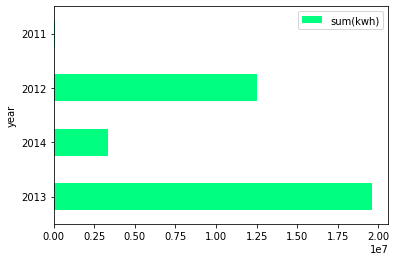

In [40]:
Energy_Total_df.plot(kind='barh',x='year',y='sum(kwh)',colormap='winter_r')

In [43]:
Energy_Total_hour= df4.groupby("hour").sum("kwh").orderBy("hour")

In [44]:
Energy_Total__hour_df=Energy_Total_hour.toPandas()

In [45]:
Energy_Total__hour_df

,hour,sum(kwh)
0,0,1.239179e+06
1,1,1.012919e+06
2,2,8.718021e+05
3,3,8.060688e+05
4,4,8.017403e+05
5,5,8.784814e+05
6,6,1.098781e+06
7,7,1.346582e+06
8,8,1.491711e+06
9,9,1.508027e+06


<AxesSubplot:xlabel='hour'>

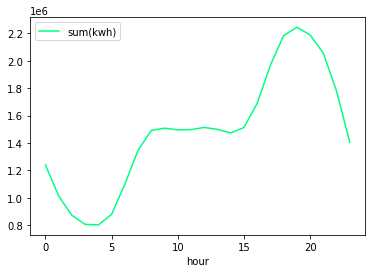

In [48]:
Energy_Total__hour_df.plot(kind='line',x='hour',y='sum(kwh)',colormap='winter_r')

In [59]:
Energy_Total_month= df4.groupby("month").sum("kwh").orderBy("month")

In [60]:
Energy_Total__month_df=Energy_Total_month.toPandas()

In [62]:
Energy_Total__month_df

,month,sum(kwh)
0,1,4.162616e+06
1,2,3.696300e+06
2,3,2.391070e+06
3,4,2.125795e+06
4,5,2.284001e+06
5,6,2.349512e+06
6,7,2.510983e+06
7,8,2.480945e+06
8,9,2.649542e+06
9,10,3.203642e+06


<AxesSubplot:xlabel='month'>

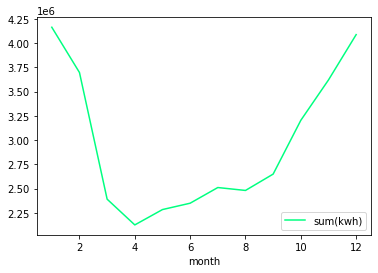

In [63]:
Energy_Total__month_df.plot(kind='line',x='month',y='sum(kwh)',colormap='winter_r')

In [ ]:
#create new dataset move the  hours from rows to coloumns 

In [ ]:
pivot_Energy = df_4.groupby("id","year","month","date").pivot("hour").sum("kwh")

In [14]:
#For each household id take thje hrous to coloumn and the agragate with the total energy co
df8=df5.groupby("id","std","year","month","date","hour").sum("kwh")


print("Before casting")
df8.printSchema()
df8_hours=df8.withColumn("hours",df8['hour'].cast('integer'))
print("After casting")
df8_hours.printSchema()

pivot_df = df8_hours.groupby("id","year","month","date").pivot("hours").sum("sum(kwh)")


#apply for all data in the dataset the aggregation sums

#first we aggregate in hours , in this data set we have every half hour so we sum every hour
# In the Eveddent dataset we do not need to aggredate every hour
df_all8=df5.groupby("id","std","year","month","date","hour").sum("kwh")
#make ne aggregation per data


from pyspark.sql import functions as f

#create agragate columns for one day avg/max.min/standard division and sum of energy 
df_all_statistics=df5.groupby("id","std","year","month","date").agg(f.sum("kwh"),f.avg("kwh"),f.max("kwh"),f.min("kwh"),f.count("kwh"),f.stddev_pop("kwh"))


Before casting
root
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sum(kwh): double (nullable = true)

After casting
root
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- sum(kwh): double (nullable = true)
 |-- hours: integer (nullable = true)



NameError: name 'pivot_df' is not defined

In [76]:
for i in pivot_df.head(5):
    print(i)

Row(id='MAC000002', year=2012, month=10, date=12, 0=0.0, 1=0.0, 2=0.0, 3=0.0, 4=0.0, 5=0.0, 6=0.0, 7=0.0, 8=0.0, 9=0.0, 10=0.0, 11=0.143, 12=0.919, 13=0.354, 14=0.29000000000000004, 15=0.28800000000000003, 16=0.29100000000000004, 17=0.847, 18=0.42300000000000004, 19=1.413, 20=0.441, 21=0.535, 22=0.595, 23=0.5589999999999999)
Row(id='MAC000002', year=2012, month=10, date=13, 0=0.532, 1=0.531, 2=0.347, 3=0.28, 4=0.276, 5=0.275, 6=0.28300000000000003, 7=0.28300000000000003, 8=0.252, 9=0.326, 10=1.848, 11=0.26, 12=0.20900000000000002, 13=0.20900000000000002, 14=0.34800000000000003, 15=0.369, 16=0.308, 17=0.406, 18=0.648, 19=1.1960000000000002, 20=0.506, 21=0.463, 22=0.423, 23=0.509)
Row(id='MAC000002', year=2012, month=10, date=14, 0=0.42800000000000005, 1=0.314, 2=0.20800000000000002, 3=0.20600000000000002, 4=0.199, 5=0.196, 6=0.197, 7=0.195, 8=0.238, 9=0.542, 10=0.6, 11=0.796, 12=0.45, 13=0.254, 14=0.28, 15=0.23099999999999998, 16=0.256, 17=0.46399999999999997, 18=1.471, 19=2.03099999999

In [44]:
#print the df
df_all_statistics.head(5)

[Row(id='MAC000032', std='Std', year=2011, month=12, date=7, sum(kwh)=3.5269999999999997, avg(kwh)=0.15334782608695652, max(kwh)=0.692, min(kwh)=0.015, count(kwh)=23, stddev_pop(kwh)=0.20240609388825276),
 Row(id='MAC000032', std='Std', year=2011, month=12, date=8, sum(kwh)=17.6700001, avg(kwh)=0.3681250020833333, max(kwh)=2.5050001, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.5694364846124748),
 Row(id='MAC000032', std='Std', year=2011, month=12, date=9, sum(kwh)=18.41300040000001, avg(kwh)=0.38360417500000016, max(kwh)=2.5680001, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.6339574196381306),
 Row(id='MAC000032', std='Std', year=2011, month=12, date=10, sum(kwh)=21.75300010000001, avg(kwh)=0.4531875020833335, max(kwh)=2.586, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.6246162401870999),
 Row(id='MAC000032', std='Std', year=2011, month=12, date=11, sum(kwh)=19.146000000000004, avg(kwh)=0.3988750000000001, max(kwh)=2.648, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.68598

In [77]:
print("test")

test


In [19]:
#The previous print for better visual each row
for i in df_all_statistics.head(5):
    print(i)

Row(id='MAC000032', std='Std', year=2011, month=12, date=7, sum(kwh)=3.5269999999999997, avg(kwh)=0.15334782608695652, max(kwh)=0.692, min(kwh)=0.015, count(kwh)=23, stddev_pop(kwh)=0.20240609388825276)
Row(id='MAC000032', std='Std', year=2011, month=12, date=8, sum(kwh)=17.6700001, avg(kwh)=0.3681250020833333, max(kwh)=2.5050001, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.5694364846124748)
Row(id='MAC000032', std='Std', year=2011, month=12, date=9, sum(kwh)=18.41300040000001, avg(kwh)=0.38360417500000016, max(kwh)=2.5680001, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.6339574196381306)
Row(id='MAC000032', std='Std', year=2011, month=12, date=10, sum(kwh)=21.75300010000001, avg(kwh)=0.4531875020833335, max(kwh)=2.586, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.6246162401870999)
Row(id='MAC000032', std='Std', year=2011, month=12, date=11, sum(kwh)=19.146000000000004, avg(kwh)=0.3988750000000001, max(kwh)=2.648, min(kwh)=0.01, count(kwh)=48, stddev_pop(kwh)=0.68598228308632

**df_all_statistics is the final dayly aggregation**

In [20]:
#df_all_statistics is the final dayly aggregation
df_all_statistics.count()

3510433

In [68]:
print("Before casting")
df7.printSchema()




Before casting
root
 |-- DateTime: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- std: string (nullable = true)
 |-- kwh: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- min: integer (nullable = true)
 |-- LCLid: string (nullable = true)
 |-- stdorToU: string (nullable = true)
 |-- Acorn: string (nullable = true)
 |-- Acorn_grouped: string (nullable = true)
 |-- file: string (nullable = true)



In [71]:
#df_all_hours=df_all8.withColumn("hours",df_all8['hour'].cast('integer'))
#print("After casting")
#df_all_hours.printSchema()
pivot_df_all=df7.groupby("id","year","month","date").pivot("hour").sum("kwh")
#dataset = pivot_df_all.groupby("id","year","month","date").sum("sum(kwh)").avg("sum(kwh)")("sum(kwh)").min("sum(kwh)").count("sum(kwh)").std("sum(kwh)")

pivot_df_all.count()

505

In [73]:
pivot_df_all.show()

+---------+----+-----+----+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+
|       id|year|month|date|                  0|                  1|                  2|                  3|                  4|                  5|                  6|                  7|                  8|                 9|                 10|                 11|                 12|                 13|                 14|                 15|                 16|                 17|                 18|                19|                 20|                 21|                22|           

In [ ]:
#pivot_df is the final dayly dataset with data schema

In [ ]:
pivot_df_all.print

In [ ]:
#moreover the pivot dayly has the hourly energy consumtin at coloums and there is a coloumn with the total energy consumtion

In [45]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt


import pandas as pd

from datetime import datetime
import calendar
import warnings
warnings.filterwarnings("ignore")


In [46]:

# Reading Household info data
df_houtio sehold = pd.read_csv("data/add/informations_households.csv", encoding="utf-8")

#household convert spark  dataframe
householdd=spark.createDataFrame(df_household)

In [47]:
df_4=df3.withColumn("kwh", df3.kwh.cast('double'))
#Join two DataSet
df4=df3.join(householdd, df3.id == householdd.LCLid, 'left')

df5=df4.withColumn("kwh", df4.kwh.cast('double'))

dff_2012=df5.filter(df5.year=='2012')
dff_2013=df5.filter(df5.year=='2013')
dff_2014=df5.filter(df5.year=='2014')


In [48]:



df8_hours=dff_2012.withColumn("hours",dff_2012['hour'].cast('integer'))


Energy_Total2012 = dff_2012.groupby("year").sum("kwh")


In [49]:

#aggragate function and hours cosumtion at coloumns
pivot_df_2012 = df_4.groupby("id","year","month","date").pivot("hour").sum("kwh")

pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [72]:
Energy_Months2012

,month,sum(kwh)
0,1,187845.99499
1,2,280490.43099
2,3,354919.33499
3,4,497697.70101
4,5,803443.58199
5,6,1011463.46600
6,7,1188737.91597
7,8,1195059.26099
8,9,1274225.74199
9,10,1671514.69801


<AxesSubplot:ylabel='month'>

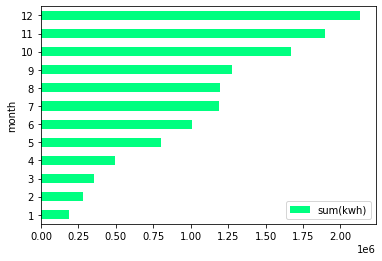

In [50]:
Energy_Months2012 = dff_2012.groupby("month").sum("kwh").orderBy("month").toPandas()

Energy_Months2012.plot(kind='barh',x='month',y='sum(kwh)',colormap='winter_r')




In [51]:
plt.show()


In [60]:
Energy_Months2012["month"]


,month,sum(kwh)
0,1,187845.99499
1,2,280490.43099
2,3,354919.33499
3,4,497697.70101
4,5,803443.58199
5,6,1011463.46600
6,7,1188737.91597
7,8,1195059.26099
8,9,1274225.74199
9,10,1671514.69801


In [61]:
Energy_Months2012["sum(kwh)"]

0     187845.99499
1     280490.43099
2     354919.33499
3     497697.70101
4     803443.58199
5    1011463.46600
6    1188737.91597
7    1195059.26099
8    1274225.74199
9    1671514.69801
10   1900102.99995
11   2129816.48496
Name: sum(kwh), dtype: float64

In [62]:
def f(t):
    return np.exp(-t) * np.cos(2*np.pi*t)

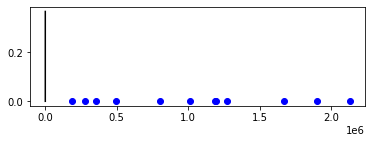

In [65]:
plt.figure()
plt.subplot(211)
plt.plot(Energy_Months2012["sum(kwh)"], f(Energy_Months2012["sum(kwh)"]), 'bo', Energy_Months2012["month"], f(Energy_Months2012["month"]), 'k')

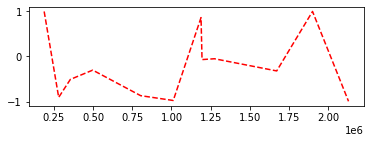

In [66]:
plt.subplot(212)
plt.plot(Energy_Months2012["sum(kwh)"], np.cos(2*np.pi*Energy_Months2012["sum(kwh)"]), 'r--')
plt.show()

<AxesSubplot:xlabel='month'>

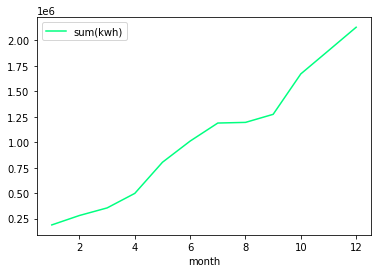

In [67]:
Energy_Months2012.plot(kind='line',x='month',y='sum(kwh)',colormap='winter_r')

In [ ]:
k